## Introduction

<br />
This tutorial will go through the steps required to produce the Long Time Series Products (LTSPs).
<br />

The aim is to create a mooring plotting "package" that produces plots for the automatic QAQC report, gets basic stats, outputs files and plots useful for model comparisons.

<br />

#### Workflow:

*  LTSPs automatically created at time of QC reporting. 
*  We use the hourly LTSP as a starting point for the mooring figures and analysis.
*  Creation of standalone functions / library, one main plotting script that draws on these functions

#### Uses: 

1.  QC and reporting 
2.  Model validation 
3.  Useful Python functions / plots for research 

### Add packages

In [3]:
# change directory to aodntools where scripts are stored
import os
os.chdir('/Users/michaelhemming/Desktop/PUG/Code/python-aodntools-master/' +
          'python-aodntools-master/')
# Velocity LTSPs
import aodntools.timeseries_products.velocity_aggregated_timeseries as vat
import aodntools.timeseries_products.velocity_hourly_timeseries as vatrly
# Temp/other LTSPs
import aodntools.timeseries_products.aggregated_timeseries as agg
import aodntools.timeseries_products.hourly_timeseries as hrly
import aodntools.timeseries_products.gridded_timeseries as grid
# get file list
# import geoserverCatalog as gc # not needed today as we are using files stored on the server
# other useful packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy.matlib

## Create An Aggregated Data Product

![](slide_1.PNG)    

### Preparing for aggregation


#### Mount the IMOS KDM server

We need to access mooring files that are stored in a folder called 'sci-maths-ocean'. This folder is accessible within the KDM server but you will have to do a couple of steps to access.  

#### What I do (Windows):

1.  Open Windows PowerShell (or PuTTY), 
    login to KDM -> 'ssh zpass@kdm.restech.unsw.edu.au' with password, <br>
    type 'network' and enter same password as Zpass. 
2.  Open 'SFTP Drive' program, 
    mount KDM server (kdm.restech.unsw.edu.au). 
    I can now open the folder interactively.
    
#### Mac users?
You can use the terminal program that is already available, and you can mount the 'sci-maths-ocean' folder directly using finder and option "Connect to Server" I believe.     
    
#### Troubleshooting:
    
Entering 'network' doesn't work? check with the administrator (Duncan Smith et al at maths IT, SCI Maths Helpdesk <helpdesk.mathsstats@unsw.edu.au>) as you may not have permission. 

Other errors when using 'network'? try 'network -u' first which should clear any residual mounts. You will occassionally have to type 'network' as sometimes the mounted folder opens but does not contain files. 
    
Files should be accessible without using the vpn. 
    
### Finding the files
    
![Logged in](logged_in.PNG)    

Go to Z:\home\z3526971\sci-maths-ocean\IMOS\DATA\MOORINGS\PROCESSED_2_5

![Logged in](sites.PNG)        
    
### Get a list of mooring files that we want to aggregate  

Let's choose PH100 temperature 

We will only select one year of data to speed things up

#### The below code is for windows, so if on mac might need to change '//' to '\\'
    

In [4]:
# Function to get file names

def get_files(mooring_dir,site_code,var,time_start,time_end):
    #######################################################################################
    # time_start   Use np.datetime64 or '' if no start limit
    # time_end   Use np.datetime64 or '' if no end limit
    #######################################################################################
    # Includes the files that has data within this range, but does not slice the file.
    # So aggregated product will not exactly have the input time range
    #######################################################################################
    path = mooring_dir + '\\' + site_code + '\\' + var + '\\' # need double '\'
    files = os.listdir(path)
    #######################################################################################
    # remove non-netCDF formats
    for n in range(len(files)):
        if '.nc' not in files[n]:
            files[n] = []
    # remove all empty slots
    files = [ele for ele in files if ele != []]
    #######################################################################################
    # remove files outside of time range
    if 'datetime64' in str(type(time_start)):
        for n in range(len(files)):
            ###############################################
            # get start and end date of file
            f = files[n]
            # Identify all underscores in filename to get dates
            underscore_index = [nn for nn in range(len(f)) if f.find('_', nn) == nn]
            start_date = f[underscore_index[2]+1:underscore_index[3]-1]
            end_date = f[underscore_index[6]+5:underscore_index[7]-1]
            # convert to numpy datetime64
            start_date = np.datetime64(start_date[0:4] + '-' + start_date[4:6] 
                                       + '-' + start_date[6:8])
            end_date = np.datetime64(end_date[0:4] + '-' + end_date[4:6] 
                                       + '-' + end_date[6:8])
            # NOTE: untested for other variables, I'd assume that it would work with IMOS standardised file names
            ###############################################
            # if no input for time_start and time_end, get earliest date
            if '-' not in str(time_start):
                time_start = np.datetime64('2008-01-01')
            if '-' not in str(time_end):
                time_end = np.datetime64('2030-01-01')
            ###############################################
            # remove file if outside of the time range
            if start_date < time_start or end_date > time_end:
                files[n] = []
    # again, remove files outside of time range
    files = [ele for ele in files if ele != []]
    return files, path

In [6]:
# Define site code and variable of interest
site_code = 'PH100'
var = 'TEMPERATURE'
time_start = np.datetime64('2021-01-01')
time_end = '' # if left as '' no end date limit
mooring_dir = 'Z:\\home\\z3526971\\sci-maths-ocean\\IMOS\\DATA\\MOORINGS\\PROCESSED_2_5\\'
# get file list
files, path = get_files(mooring_dir,site_code,var,time_start,time_end)
# print first 10 files
files[0:10]

['IMOS_ANMN-NSW_TZ_20210401T012500Z_PH100_FV01_PH100-2104-Aqualogger-AQUAlogger-520T-max1000m-56_END-20210615T020000Z_C-20210702T020211Z.nc',
 'IMOS_ANMN-NSW_TZ_20210111T005500Z_PH100_FV01_PH100-2101-Aqualogger-520T-80_END-20210331T234000Z_C-20210415T062122Z.nc',
 'IMOS_ANMN-NSW_TZ_20210615T024500Z_PH100_FV01_PH100-2106-Aqualogger-AQUAlogger-520PT16-max160m-104_END-20210901T004000Z_C-20210910T052028Z.nc',
 'IMOS_ANMN-NSW_TZ_20210401T012500Z_PH100_FV01_PH100-2104-Aqualogger-AQUAlogger-520PT16-max160m-104_END-20210615T020000Z_C-20210702T020209Z.nc',
 'IMOS_ANMN-NSW_TZ_20210111T005500Z_PH100_FV01_PH100-2101-Aqualogger-AQUAlogger-520PT16-max160m-104_END-20210331T234000Z_C-20210415T062121Z.nc',
 'IMOS_ANMN-NSW_TZ_20210111T005500Z_PH100_FV01_PH100-2101-Aqualogger-520T-56_END-20210331T234000Z_C-20210415T062123Z.nc',
 'IMOS_ANMN-NSW_TZ_20210901T005500Z_PH100_FV01_PH100-2109-Aqualogger-AQUAlogger-520T-max1000m-32_END-20211215T003500Z_C-20220224T011135Z.nc',
 'IMOS_ANMN-NSW_TZ_20210615T024500Z_P

In [7]:
len(files)

52

In [8]:
path

'Z:\\home\\z3526971\\sci-maths-ocean\\IMOS\\DATA\\MOORINGS\\PROCESSED_2_5\\\\PH100\\TEMPERATURE\\'

### Aggregate temperature files

In [12]:
agg.main_aggregator(files, 'TEMP', site_code, input_dir=path, 
                    output_dir='', download_url_prefix=None, opendap_url_prefix=None)

# NOTE: I kept getting errors for xarray dependencies, so I added 'engine='netcdf4' 
# on line 227 in 'aggregated_timeseries.py' and it worked

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mphem\\Documents\\Work\\UNSW\\LTSP\\Code\\python-aodntools-master\\python-aodntools-master\\tmp9uss30h7.nc'

## -----------------------------------
## Ignore error, it works!
#### Related to temporary nc file. Not Agg data product.
## -----------------------------------

### Data Product Information

In [7]:
filename = 'IMOS_ANMN-NSW_TZ_20210111_PH100_FV01_TEMP-aggregated-timeseries_END-20211215_C-20220428.nc'
agg_data = xr.open_dataset(filename)

In [8]:
agg_data

<xarray.Dataset>
Dimensions:                   (OBSERVATION: 1235743, INSTRUMENT: 52)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LATITUDE                  (INSTRUMENT) float64 ...
    LONGITUDE                 (INSTRUMENT) float64 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: OBSERVATION, INSTRUMENT
Data variables:
    TEMP                      (OBSERVATION) float32 ...
    TEMP_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) float32 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int16 ...
    source_file               (INSTRUMENT) |S256 ...
    instrument_id             (INSTRUMENT) |S256 ...
Attributes: (12/39)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      Aggregated Time-series Product: This file ...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Klein, Eduardo
    author_email:                  eduardo.kleinsalas@utas.edu.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    site_code:                     PH100
    source:                        Mooring
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2021-12-15T00:30:00Z
    time_coverage_start:           2021-01-11T00:55:00Z
    title:                         Long Timeseries Velocity Aggregated produc...

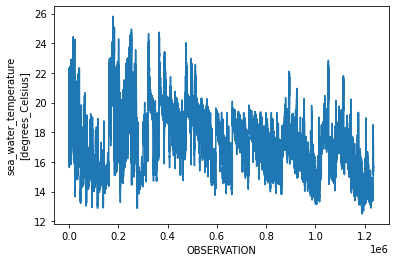

In [31]:
agg_data.TEMP.plot()

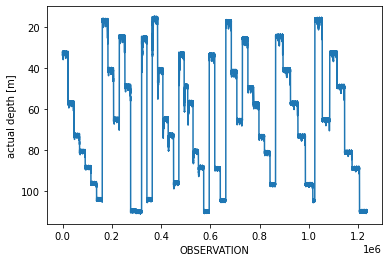

In [32]:
agg_data.DEPTH.plot()
plt.gca().invert_yaxis()

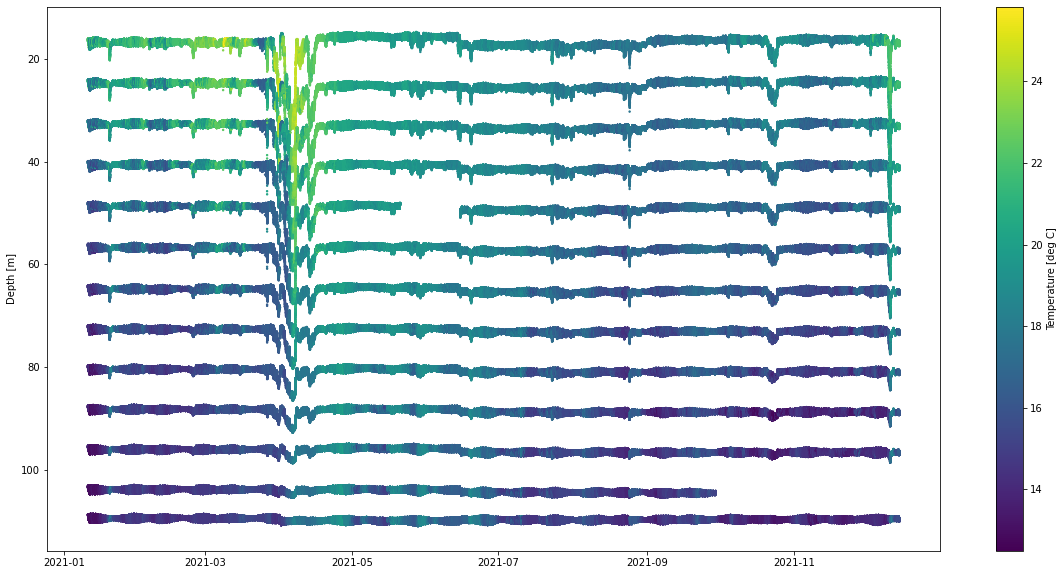

In [33]:
# %matplotlib qt
plt.figure(figsize=(20,10))
plt.scatter(agg_data.TIME,agg_data.DEPTH,c=agg_data.TEMP,s=2)
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.colorbar(label='Temperature [deg C]')
# %matplotlib inline

 ## Create An Hourly Data Product
 
 ![](slide_2.PNG) 

![](QC.PNG)


In [36]:
path

'Z:\\home\\z3526971\\sci-maths-ocean\\IMOS\\DATA\\MOORINGS\\PROCESSED_2_5\\\\PH100\\TEMPERATURE\\'

In [37]:
qcflags = [1,2] # good data, probably good data
hrly.hourly_aggregator(files, site_code, qcflags, input_dir=path, output_dir='./',
                          download_url_prefix=None, opendap_url_prefix=None);
"""
Aggregate a dataset into 1 hour intervals and calculate related statistics

:param files_to_aggregate: List of files to aggregate. Each path is interpreted relative
to input_dir (if specified). These paths are listed in the `source_files` variable in the output file.
:param site_code: code of the mooring site
:param qcflags: list of QCflags indicating what values of the variables to keep
:param input_dir: base path where source files are stored
:param output_dir: path where the result file will be written
:param download_url_prefix: URL prefix for file download (to be prepended to paths in files_to_aggregate)
:param opendap_url_prefix: URL prefix for OPENAP access (to be prepended to paths in files_to_aggregate)
:return: tuple (path of the output file, dict of rejected files and error messages)
"""

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


'\nAggregate a dataset into 1 hour intervals and calculate related statistics\n\n:param files_to_aggregate: List of files to aggregate. Each path is interpreted relative\nto input_dir (if specified). These paths are listed in the `source_files` variable in the output file.\n:param site_code: code of the mooring site\n:param qcflags: list of QCflags indicating what values of the variables to keep\n:param input_dir: base path where source files are stored\n:param output_dir: path where the result file will be written\n:param download_url_prefix: URL prefix for file download (to be prepended to paths in files_to_aggregate)\n:param opendap_url_prefix: URL prefix for OPENAP access (to be prepended to paths in files_to_aggregate)\n:return: tuple (path of the output file, dict of rejected files and error messages)\n'

In [5]:
filename = 'IMOS_ANMN-NSW_TZ_20210111_PH100_FV02_hourly-timeseries_END-20211215_C-20220428.nc'
hrly_data = xr.open_dataset(filename)

In [6]:
hrly_data

<xarray.Dataset>
Dimensions:           (OBSERVATION: 103031, INSTRUMENT: 52)
Coordinates:
    TIME              (OBSERVATION) datetime64[ns] ...
    LONGITUDE         (INSTRUMENT) float64 ...
    LATITUDE          (INSTRUMENT) float64 ...
    NOMINAL_DEPTH     (INSTRUMENT) float32 ...
Dimensions without coordinates: OBSERVATION, INSTRUMENT
Data variables: (12/18)
    instrument_index  (OBSERVATION) int32 ...
    instrument_id     (INSTRUMENT) |S256 ...
    source_file       (INSTRUMENT) |S256 ...
    DEPTH             (OBSERVATION) float32 ...
    DEPTH_count       (OBSERVATION) float32 ...
    DEPTH_min         (OBSERVATION) float32 ...
    ...                ...
    PRES_std          (OBSERVATION) float32 ...
    TEMP              (OBSERVATION) float32 ...
    TEMP_count        (OBSERVATION) float32 ...
    TEMP_max          (OBSERVATION) float32 ...
    TEMP_min          (OBSERVATION) float32 ...
    TEMP_std          (OBSERVATION) float32 ...
Attributes: (12/39)
    Conventions:                 CF-1.6,IMOS-1.4
    abstract:                    Hourly Time Series Product: This file contai...
    acknowledgement:             Any users of IMOS data are required to clear...
    author:                      Klein, Eduardo
    author_email:                eduardo.kleinsalas@utas.edu.au
    citation:                    The citation in a list of references is: "IM...
    ...                          ...
    site_code:                   PH100
    source:                      Mooring
    standard_name_vocabulary:    NetCDF Climate and Forecast (CF) Metadata Co...
    time_coverage_end:           2021-12-15T00:00:00Z
    time_coverage_start:         2021-01-11T00:00:00Z
    title:                       Long time series Hourly Aggregated product: ...

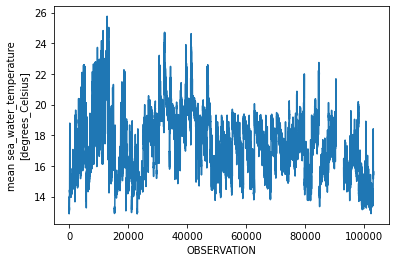

In [40]:
hrly_data.TEMP.plot()

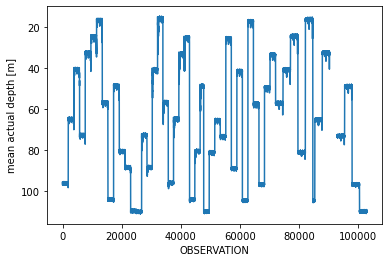

In [41]:
hrly_data.DEPTH.plot()
plt.gca().invert_yaxis()

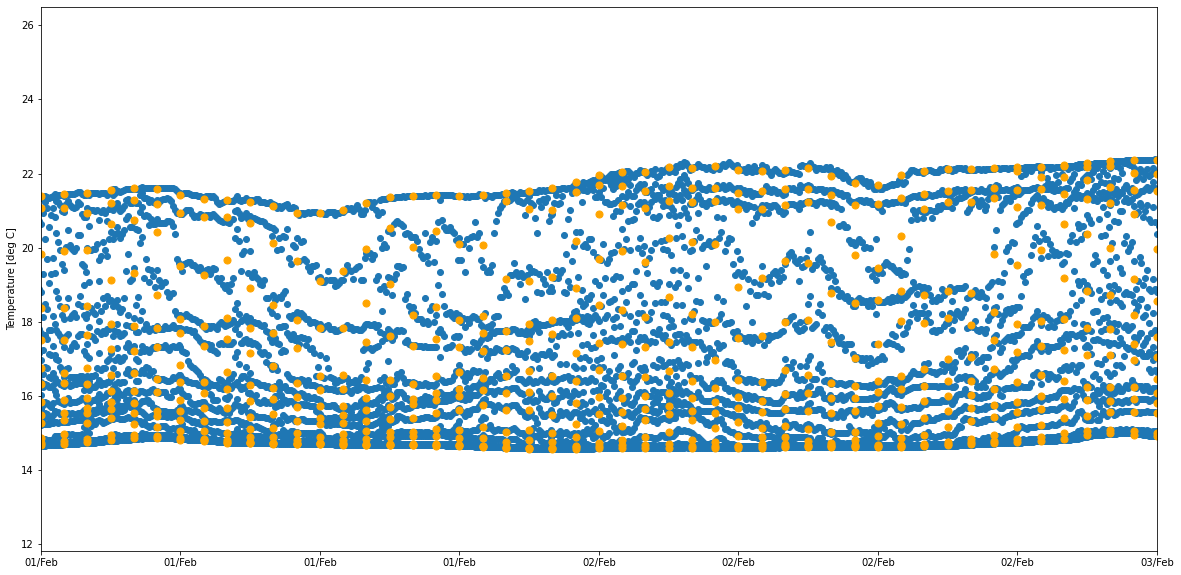

In [42]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(agg_data.TIME,agg_data.TEMP)
plt.scatter(hrly_data.TIME,hrly_data.TEMP,s=50,c='orange')
plt.xlim(left=np.datetime64('2021-02-01'),right=np.datetime64('2021-02-03'))
plt.ylabel('Temperature [deg C]')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%h'))
plt.rc('font', size=25)

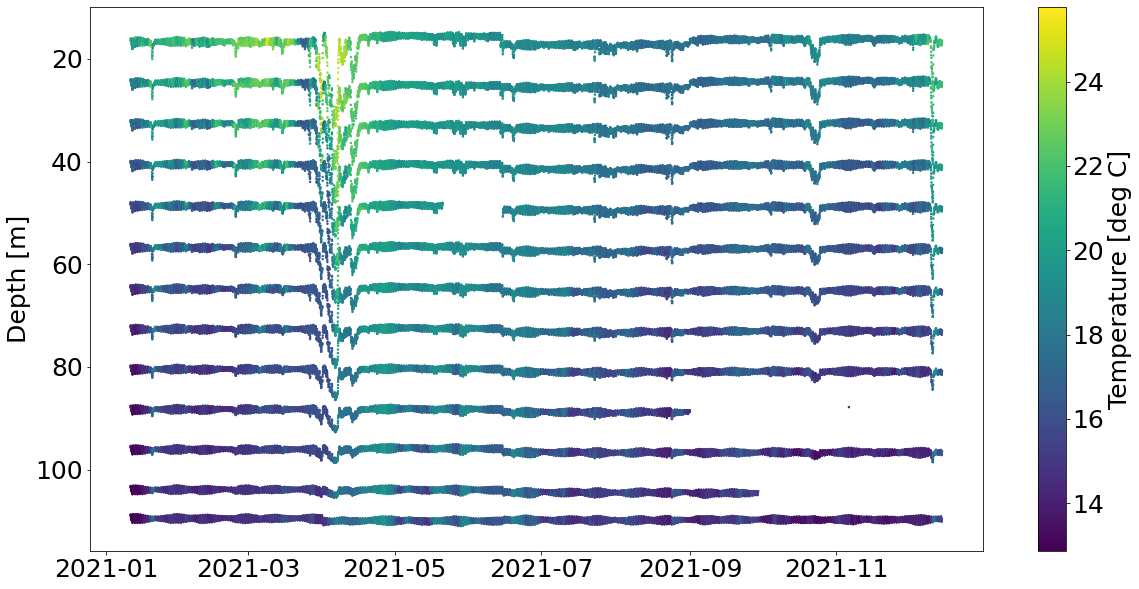

In [43]:
# %matplotlib qt
plt.figure(figsize=(20,10))
plt.scatter(hrly_data.TIME,hrly_data.DEPTH,c=hrly_data.TEMP,s=2)
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.colorbar(label='Temperature [deg C]')
# %matplotlib inline

(array([2.5440e+03, 1.0000e+00, 6.0000e+00, 1.4000e+01, 1.9000e+01,
        1.3000e+01, 1.3000e+01, 1.0000e+00, 3.3239e+04, 6.7181e+04]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

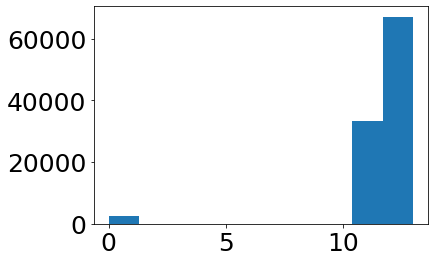

In [47]:
plt.hist(hrly_data.TEMP_count)

Text(0.5, 1.0, 'Max and Min Hourly Temperatures < 20 m Depth')

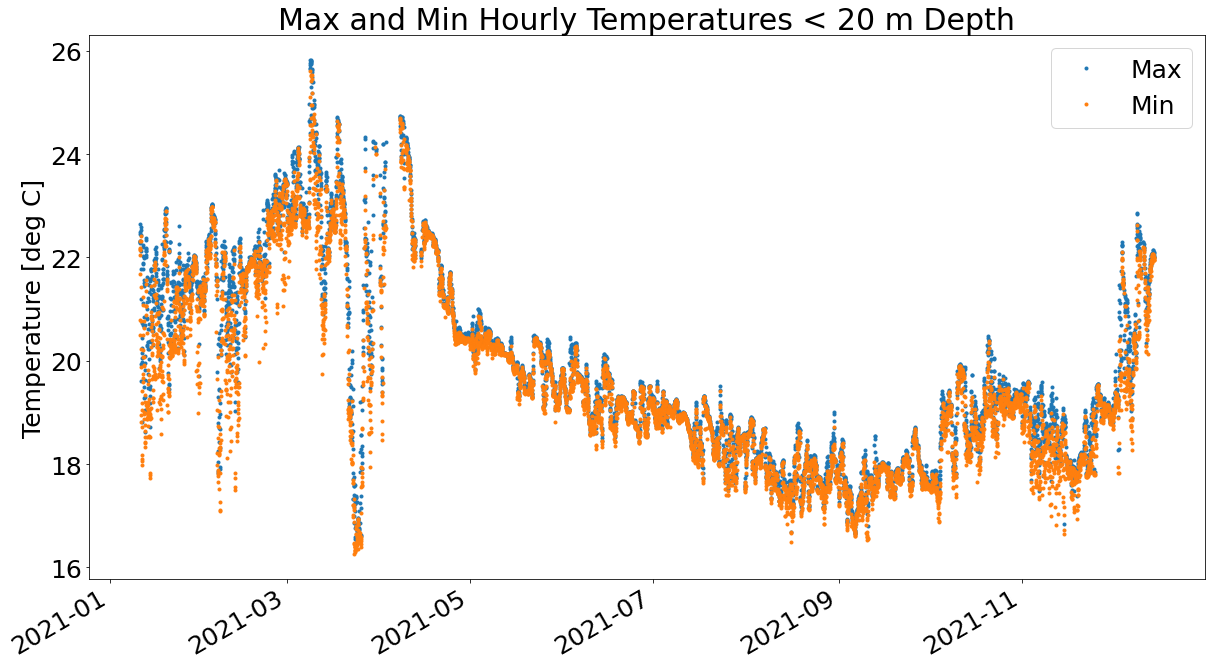

In [76]:
plt.figure(figsize=(20,10))
hrly_data.TEMP_max.where(hrly_data.DEPTH< 20).plot(x='TIME',linewidth=1,label='Max',marker='.',linestyle='')
hrly_data.TEMP_min.where(hrly_data.DEPTH< 20).plot(x='TIME',linewidth=1,label='Min',marker='.',linestyle='')
plt.legend()
plt.ylabel('Temperature [deg C]'); plt.xlabel('')
plt.title('Max and Min Hourly Temperatures < 20 m Depth')

## Create a Gridded Data Product

![](slide_3.PNG)      

In [9]:
hourly_file = filename
filename

'IMOS_ANMN-NSW_TZ_20210111_PH100_FV01_TEMP-aggregated-timeseries_END-20211215_C-20220428.nc'

In [78]:
resolution = 1
separation = 50

grid.grid_variable(hourly_file, 'TEMP', depth_bins=None, max_separation=separation, depth_bins_increment=resolution,
                  input_dir='', output_dir='.', download_url_prefix=None, opendap_url_prefix=None)
    
"""
Grid VoI into depth_bins.
:param input_file: Input hourly aggregated file with VoI, DEPTH and TIME only (path interpreted relative
to input_dir, if specified)
:param VoI: variable of interest (TEMP or PSAL)
:param depth_bins: list of depth where to interpolate. if null list is provided it will be calculated from the data
:param max_separation: max separation allowed for instruments
:param depth_bins_increment: in case no depth bins provided this is the increment for the calculated bins
:param input_dir: base path where source files are stored
:param output_dir: path where the result file will be written
:param download_url_prefix: URL prefix for file download (to be prepended to input_file path)
:param opendap_url_prefix: URL prefix for OPENAP access (to be prepended to input_file path)
:return: path of interpolated output file
"""    
    

C:\Users\mphem\Documents\Work\UNSW\LTSP\Code\python-aodntools-master\python-aodntools-master\aodntools\timeseries_products\gridded_timeseries.py:88: SerializationWarning: saving variable TEMP_count with floating point data as an integer dtype without any _FillValue to use for NaNs
  agg_dataset.to_netcdf(output_path, encoding=encoding, format='NETCDF4_CLASSIC')


'\nGrid VoI into depth_bins.\n:param input_file: Input hourly aggregated file with VoI, DEPTH and TIME only (path interpreted relative\nto input_dir, if specified)\n:param VoI: variable of interest (TEMP or PSAL)\n:param depth_bins: list of depth where to interpolate. if null list is provided it will be calculated from the data\n:param max_separation: max separation allowed for instruments\n:param depth_bins_increment: in case no depth bins provided this is the increment for the calculated bins\n:param input_dir: base path where source files are stored\n:param output_dir: path where the result file will be written\n:param download_url_prefix: URL prefix for file download (to be prepended to input_file path)\n:param opendap_url_prefix: URL prefix for OPENAP access (to be prepended to input_file path)\n:return: path of interpolated output file\n'

In [10]:
filename = 'IMOS_ANMN-NSW_TZ_20210111_PH100_FV02_TEMP-gridded-timeseries_END-20211215_C-20220428.nc'
grd_data = xr.open_dataset(filename)

In [11]:
grd_data

<xarray.Dataset>
Dimensions:     (TIME: 8113, DEPTH: 97)
Coordinates:
  * DEPTH       (DEPTH) float32 14.0 15.0 16.0 17.0 ... 107.0 108.0 109.0 110.0
  * TIME        (TIME) datetime64[ns] 2021-01-11 ... 2021-12-15
    LONGITUDE   float64 ...
    LATITUDE    float64 ...
Data variables:
    TEMP        (TIME, DEPTH) float32 ...
    TEMP_count  (TIME) int16 ...
Attributes: (12/39)
    Conventions:                 CF-1.6,IMOS-1.4
    abstract:                    Gridded Time Series Product: This file conta...
    acknowledgement:             Any users of IMOS data are required to clear...
    author:                      Klein, Eduardo
    author_email:                eduardo.kleinsalas@utas.edu.au
    citation:                    The citation in a list of references is: "IM...
    ...                          ...
    source:                      Mooring
    source_file:                 IMOS_ANMN-NSW_TZ_20210111_PH100_FV02_hourly-...
    standard_name_vocabulary:    NetCDF Climate and Forecast (CF) Metadata Co...
    time_coverage_end:           2021-12-15T00:00:00Z
    time_coverage_start:         2021-01-11T00:00:00Z
    title:                       Gridded Time Series Product: TEMP interpolat...

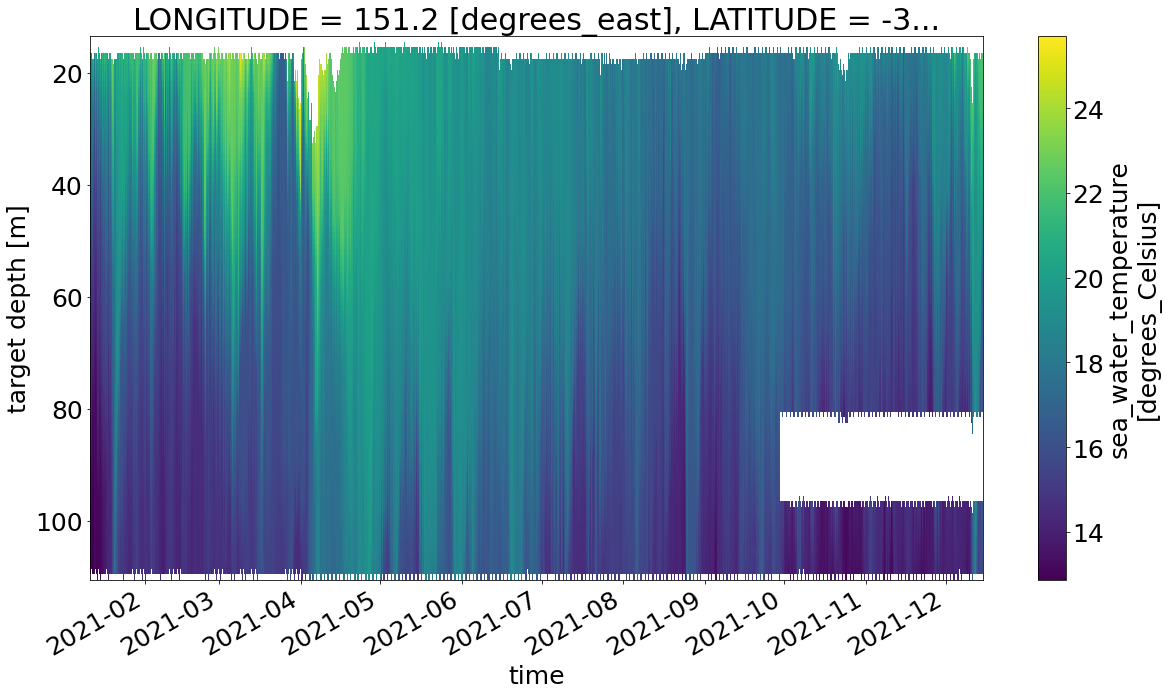

In [82]:
# %matplotlib qt
plt.figure(figsize=(20,10))
grd_data.TEMP.plot(x='TIME',y='DEPTH')
plt.gca().invert_yaxis()
plt.rc('font', size=20)
# %matplotlib inline

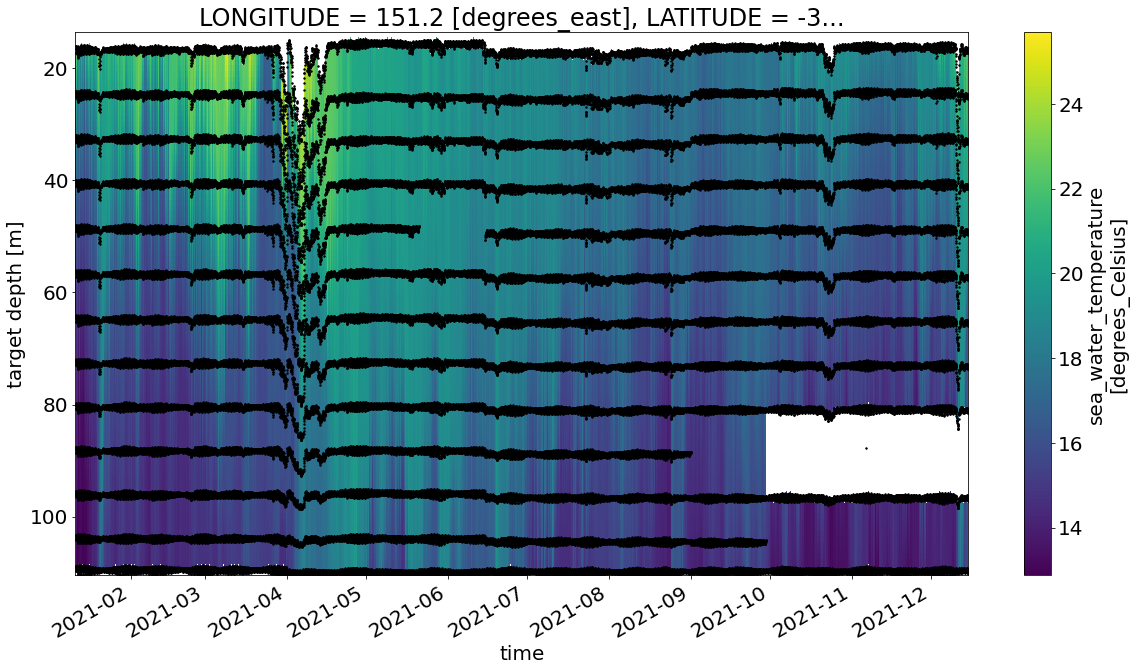

In [83]:
# %matplotlib qt
plt.figure(figsize=(20,10))
grd_data.TEMP.plot(x='TIME',y='DEPTH')
plt.scatter(hrly_data.TIME,hrly_data.DEPTH,c='k',s=2)
plt.gca().invert_yaxis()
plt.rc('font', size=20)
# %matplotlib inline

Text(0, 0.5, '# observations per timestep')

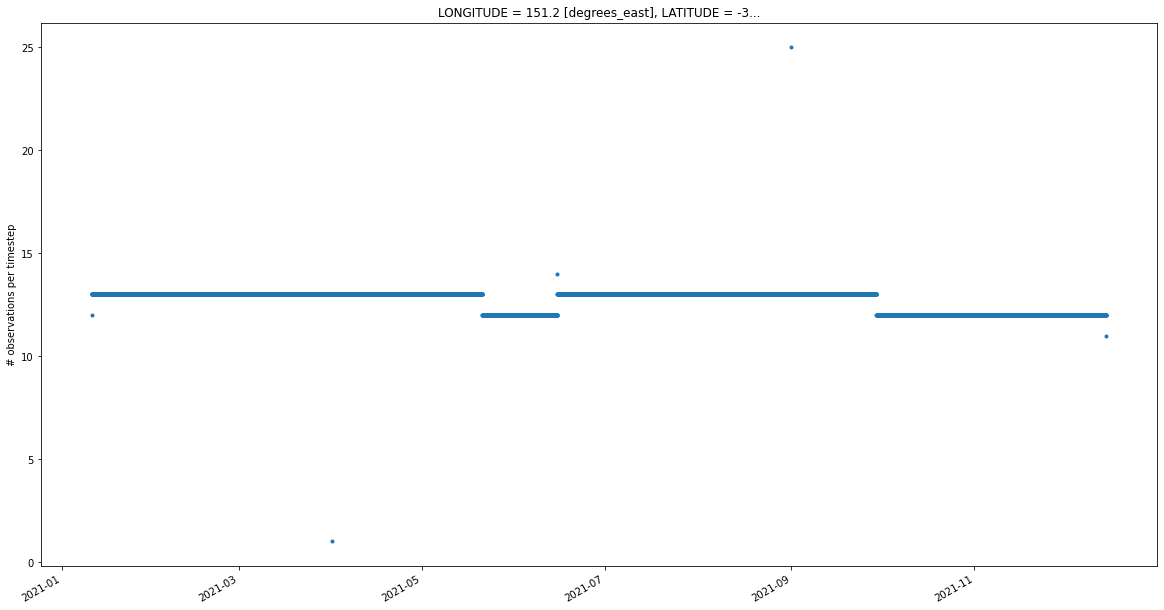

In [91]:
# %matplotlib qt
plt.figure(figsize=(20,10))
grd_data.TEMP_count.plot(marker='.',linestyle='')
plt.xlabel(''); plt.ylabel('# observations per timestep')
# %matplotlib inline

### Grid every e.g. 10 m instead

In [92]:
resolution = 10
separation = 50

grid.grid_variable(hourly_file, 'TEMP', depth_bins=None, max_separation=separation, depth_bins_increment=resolution,
                  input_dir='', output_dir='./grid_example/', download_url_prefix=None, opendap_url_prefix=None)

C:\Users\mphem\Documents\Work\UNSW\LTSP\Code\python-aodntools-master\python-aodntools-master\aodntools\timeseries_products\gridded_timeseries.py:88: SerializationWarning: saving variable TEMP_count with floating point data as an integer dtype without any _FillValue to use for NaNs
  agg_dataset.to_netcdf(output_path, encoding=encoding, format='NETCDF4_CLASSIC')


'./grid_example/IMOS_ANMN-NSW_TZ_20210111_PH100_FV02_TEMP-gridded-timeseries_END-20211215_C-20220502.nc'

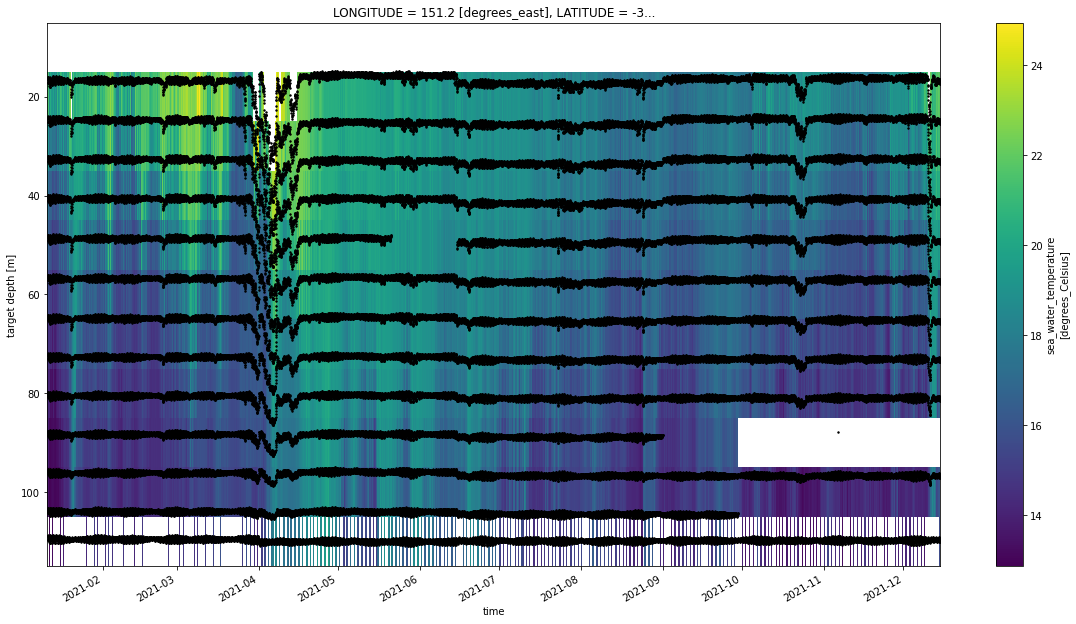

In [93]:
filename = './grid_example/IMOS_ANMN-NSW_TZ_20210111_PH100_FV02_TEMP-gridded-timeseries_END-20211215_C-20220502.nc'
grd_data_10 = xr.open_dataset(filename)


# %matplotlib qt
plt.figure(figsize=(20,10))
grd_data_10.TEMP.plot(x='TIME',y='DEPTH')
plt.scatter(hrly_data.TIME,hrly_data.DEPTH,c='k',s=2)
plt.gca().invert_yaxis()
plt.rc('font', size=20)
# %matplotlib inline

![](slide_4.PNG) 

## Next Steps .. (to discuss)

<br>

*  Create LTSPs for full time series (might need Katana). Might need a batch script
*  Create velocity aggregated and hourly LTSPs 
*  Create gridded velocity product as not yet available. Perhaps adapt other LTSP code?
*  Code to aggregate a newly updated LTSP (e.g. 3 months of data) with the existing LTSP saved on the server, to save time. <br> xarray.concat? (https://docs.xarray.dev/en/stable/generated/xarray.concat.html)

## Issues: missing data? (above figures)

In [12]:
missing_data = xr.open_dataset(('http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANMN/NSW/PH100/' +
                               'Temperature/IMOS_ANMN-NSW_TZ_20210901T005500Z_PH100_FV01_PH100' +
                               '-2109-Aqualogger-AQUAlogger-520T-max1000m-88_END-20211215T003500Z_' +
                               'C-20220224T011133Z.nc'))

In [15]:
bad_data = (np.sum(np.array(missing_data.TEMP_quality_control) == 4)
            /len(missing_data.TEMP_quality_control))*100
no_QC = (np.sum(np.array(missing_data.TEMP_quality_control) == 0)
            /len(missing_data.TEMP_quality_control))*100
bad_data_potentially_correctable = (np.sum(np.array(missing_data.TEMP_quality_control) == 3)
            /len(missing_data.TEMP_quality_control))*100

In [16]:
print('bad data = ' + str(np.round(bad_data,2)) + ' % , bad data potentially correctable = ' 
                    + str(np.round(bad_data_potentially_correctable,2)) + ' %')

bad data = 5.07 % , bad data potentially correctable = 94.93 %


## Issues: gaps in gridded version

![](gappy_data.PNG)      

<pre>

When running the for loop on line 190 in 'grid_variable' function in 'gridded_timeseries.py' for a date when there is missing gridded data, I get the following:



VoI_values = [16.7461, 18.769634, 17.33436, nan, 15.591092, 14.718737, 17.733799, 19.18304, 16.496675, 15.4011135, 15.960257, 13.950939]

depth = [48.674, 24.185463, 40.511154, nan, 72.88726, 96.549965, 32.34831, 16.022615, 56.836845, 80.774826, 64.999695, 109.65999]



then, after sorting on line 198 using function 'sort_depths' I get the following:



VoI_values = [18.769634, 17.33436, 16.7461, nan, 19.18304, 17.733799, 16.496675, 15.960257, 15.591092, 15.4011135, 14.718737, 13.950939]

depth = [24.185463, 40.511154, 48.674, nan, 16.022615, 32.34831, 56.836845, 64.999695, 72.88726, 80.774826, 96.549965, 109.65999]


The variable 'depth_mask' assigns the near surface data as False and the interpolated data is removed. Although I don't fully understand why this happens yet using the above VoI_values and depth as input. My guess is because of the nan and the incorrect sorting.


As a quick fix I added the following on lines 197-201 before the depth and VoI are sorted using function 'sort_depths':


if np.sum(np.logical_and(np.isnan(depth), np.isnan(VoI_values))) > 0:
    c = np.logical_and(np.isfinite(depth), np.isfinite(VoI_values)).transpose()
    VoI_values = list(np.array(VoI_values)[c])
    depth = list(np.array(depth)[c])

</pre>

The hourly data is now interpolated throughout the water column during this time, with the 16-24 m white space in the plot attached now interpolated over.

## Creating a velocity aggregated product

In [42]:
# Define site code and variable of interest
site_code = 'PH100'
var = 'CURRENT'
time_start = np.datetime64('2021-01-01')
time_end = '' # if left as '' no end date limit
mooring_dir = 'Z:\\home\\z3526971\\sci-maths-ocean\\IMOS\\DATA\\MOORINGS\\PROCESSED_2_5\\'
# get file list
files, path = get_files(mooring_dir,site_code,var,time_start,time_end)
# print first 10 files
files[0:10]

FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\home\\z3526971\\sci-maths-ocean\\IMOS\\DATA\\MOORINGS\\PROCESSED_2_5\\\\PH100\\CURRENT\\'

In [16]:
len(files)

5

In [15]:
path

'Z:\\home\\z3526971\\sci-maths-ocean\\IMOS\\DATA\\MOORINGS\\PROCESSED_2_5\\\\PH100\\CURRENT\\'

In [17]:
vat.velocity_aggregated(files, site_code, input_dir=path, output_dir='./',
                        download_url_prefix=None, opendap_url_prefix=None)

0
1
2
3
4


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\z3526971\\OneDrive - UNSW\\Work\\LTSP\\Code\\python-aodntools-master\\python-aodntools-master\\tmpvf8b7jk_.nc'

In [17]:
filename = 'IMOS_ANMN-NSW_VZ_20210111_PH100_FV01_velocity-aggregated-timeseries_END-20220317_C-20220617.nc'
Vagg_data = xr.open_dataset(filename)

In [20]:
Vagg_data 

<xarray.Dataset>
Dimensions:                (OBSERVATION: 3102125, INSTRUMENT: 5)
Coordinates:
    DEPTH                  (OBSERVATION) float32 ...
    TIME                   (OBSERVATION) datetime64[ns] ...
    LATITUDE               (INSTRUMENT) float64 ...
    LONGITUDE              (INSTRUMENT) float64 ...
    NOMINAL_DEPTH          (INSTRUMENT) float32 ...
Dimensions without coordinates: OBSERVATION, INSTRUMENT
Data variables:
    UCUR                   (OBSERVATION) float32 ...
    VCUR                   (OBSERVATION) float32 ...
    WCUR                   (OBSERVATION) float32 ...
    UCUR_quality_control   (OBSERVATION) float32 ...
    VCUR_quality_control   (OBSERVATION) float32 ...
    WCUR_quality_control   (OBSERVATION) float32 ...
    DEPTH_quality_control  (OBSERVATION) float32 ...
    instrument_index       (OBSERVATION) int16 ...
    source_file            (INSTRUMENT) |S256 ...
    instrument_id          (INSTRUMENT) |S256 ...
    SECONDS_TO_MIDDLE      (INSTRUMENT) float32 ...
    CELL_INDEX             (OBSERVATION) int16 ...
Attributes: (12/39)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      Velocity Aggregated Time-series Product: T...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Klein, Eduardo
    author_email:                  eduardo.kleinsalas@utas.edu.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    site_code:                     PH100
    source:                        Mooring
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2022-03-17T23:30:50Z
    time_coverage_start:           2021-01-11T01:30:00Z
    title:                         Long Timeseries Velocity Aggregated produc...

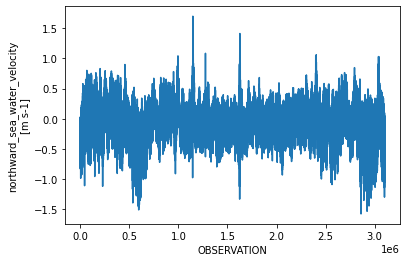

In [18]:
Vagg_data.VCUR.plot()

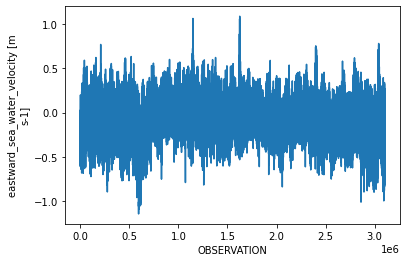

In [27]:
Vagg_data.UCUR.plot()

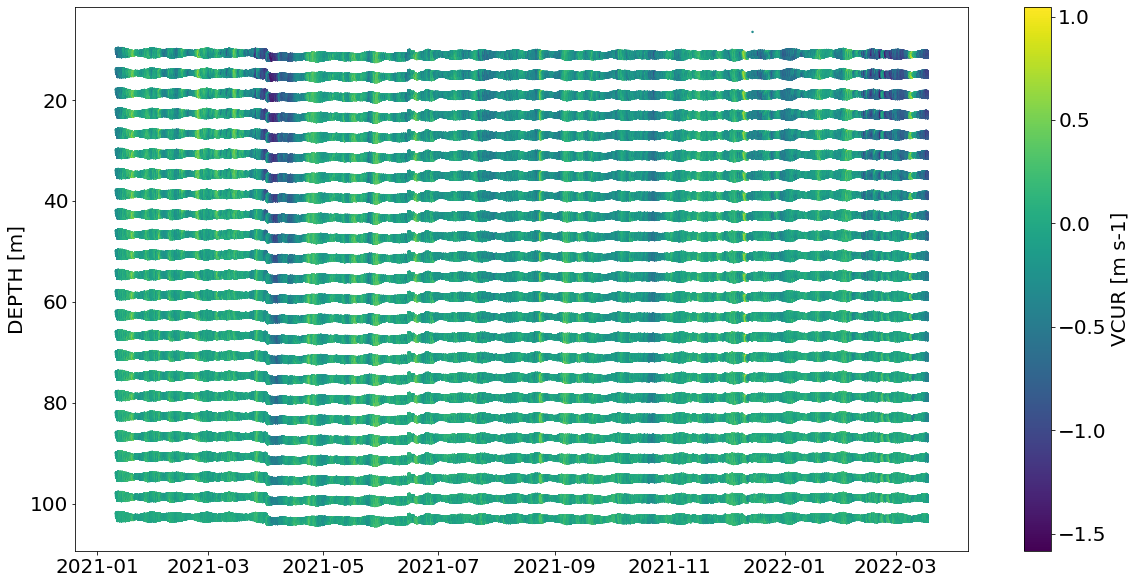

In [34]:
#%matplotlib qt
plt.figure(figsize=(20,10))
plt.scatter(Vagg_data.TIME.where(Vagg_data.VCUR_quality_control <= 2),
            Vagg_data.DEPTH.where(Vagg_data.VCUR_quality_control <= 2),
            c=Vagg_data.VCUR.where(Vagg_data.VCUR_quality_control <= 2),s=2)
plt.gca().invert_yaxis()
plt.colorbar(label='VCUR [m s-1]')
plt.ylabel('DEPTH [m]')
plt.rc('font', size=20)
#%matplotlib inline

## Getting high-res interpolated data product (gridding before hourly-averaging)

We want to have a high-resolution gridded product prior to hourly-averaging

I have created a new version of the gridding code for velocity (script '')

### (Show modified script)

In [20]:
filename = 'VCURgridded_product_UNSW.nc'
Vgrd_data = xr.open_dataset(filename)

In [21]:
Vgrd_data

<xarray.Dataset>
Dimensions:     (TIME: 124085, DEPTH: 104)
Coordinates:
  * DEPTH       (DEPTH) float64 1.0 2.0 3.0 4.0 5.0 ... 101.0 102.0 103.0 104.0
  * TIME        (TIME) datetime64[ns] 2021-01-11T01:30:00 ... 2022-03-17T23:3...
Data variables:
    VCUR        (TIME, DEPTH) float32 ...
    VCUR_count  (TIME) float64 ...
    LONGITUDE   float64 ...
    LATITUDE    float64 ...

In [27]:
Vgrd_data = Vgrd_data.transpose()

(105.0, 10.0)

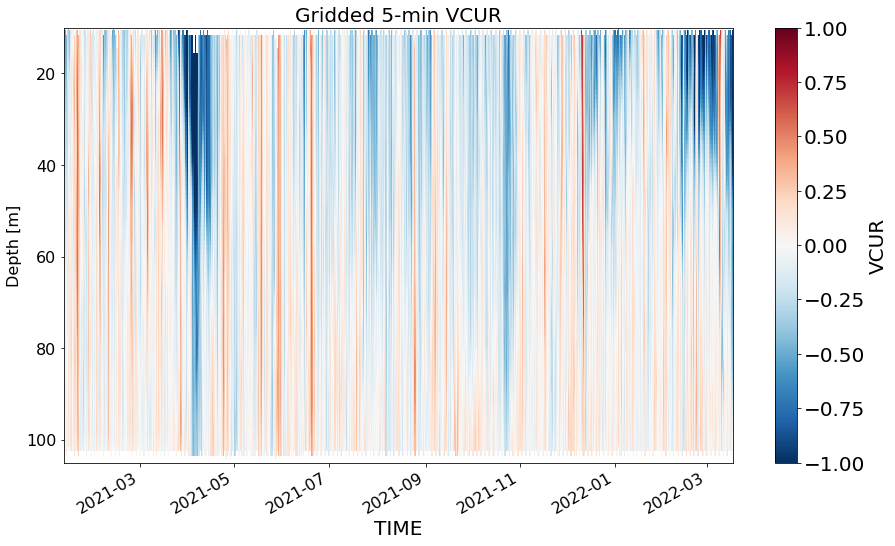

In [41]:
plt.figure(figsize=(15,8))
p = Vgrd_data.VCUR.plot()
p.set_clim(-1,1)
# plt.colorbar(label='VCUR [m s-1]')
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]',fontsize=16)
plt.title('Gridded 5-min VCUR',fontsize=20)
plt.tick_params(labelsize=16)
plt.set_cmap('bwr')
plt.ylim(105,10)

In [25]:
VCUR = np.array(Vgrd_data.VCUR).flatten()
trep = np.matlib.repmat(Vgrd_data.TIME, 1, 104).flatten()
Drep = np.matlib.repmat(Vgrd_data.DEPTH, 124085,1).flatten()

In [23]:
len(VCUR)

12904840

In [28]:
Vgrd_data.VCUR

<xarray.DataArray 'VCUR' (TIME: 124085, DEPTH: 104)>
array([[      nan,       nan,       nan, ..., -0.035635,       nan,       nan],
       [      nan,       nan,       nan, ..., -0.017286,       nan,       nan],
       [      nan,       nan,       nan, ..., -0.012452,       nan,       nan],
       ...,
       [      nan,       nan,       nan, ..., -0.032516, -0.005266,       nan],
       [      nan,       nan,       nan, ..., -0.025005, -0.001505,       nan],
       [      nan,       nan,       nan, ..., -0.004478,  0.023272,       nan]],
      dtype=float32)
Coordinates:
  * DEPTH    (DEPTH) float64 1.0 2.0 3.0 4.0 5.0 ... 101.0 102.0 103.0 104.0
  * TIME     (TIME) datetime64[ns] 2021-01-11T01:30:00 ... 2022-03-17T23:30:5...

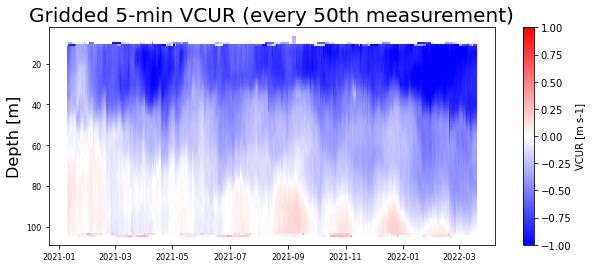

In [27]:
# %matplotlib qt
plt.figure(figsize=(10,4))
p = plt.scatter(trep,Drep,c=VCUR,
            s=10,marker='s')
p.set_clim(-1,1)
cbar = plt.colorbar(label='VCUR [m s-1]')
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]',fontsize=16)
plt.title('Gridded 5-min VCUR',fontsize=20)
plt.tick_params(labelsize=8)
plt.set_cmap('bwr')
# %matplotlib inline

### Code is not efficient. Takes ~ 30 mins per year at the moment using LTSP code. Try other gridding code?

## Creating an hourly product using LTSP code


** Future function: Using gridded product as input instead of multiple files


In [45]:
# Define site code and variable of interest
site_code = 'PH100'
var = 'CURRENT'
time_start = np.datetime64('2021-01-01')
time_end = '' # if left as '' no end date limit
mooring_dir = 'Z:\\home\\z3526971\\sci-maths-ocean\\IMOS\\DATA\\MOORINGS\\PROCESSED_2_5\\'
# get file list
files, path = get_files(mooring_dir,site_code,var,time_start,time_end)
# print first 10 files
files[0:10]

['IMOS_ANMN-NSW_AETVZ_20211215T001000Z_PH100_FV01_PH100-2112-Sentinel-or-Monitor-Workhorse-ADCP-109.5_END-20220317T233500Z_C-20220606T042208Z.nc',
 'IMOS_ANMN-NSW_AETVZ_20210111T013000Z_PH100_FV01_PH100-2101-Sentinel-or-Monitor-Workhorse-ADCP-109.5_END-20210401T002000Z_C-20210415T062120Z.nc',
 'IMOS_ANMN-NSW_AETVZ_20210901T012000Z_PH100_FV01_PH100-2109-Sentinel-or-Monitor-Workhorse-ADCP-109.5_END-20211215T000000Z_C-20220224T011131Z.nc',
 'IMOS_ANMN-NSW_AETVZ_20210615T023500Z_PH100_FV01_PH100-2106-Sentinel-or-Monitor-Workhorse-ADCP-109.5_END-20210901T005000Z_C-20210910T052026Z.nc',
 'IMOS_ANMN-NSW_AETVZ_20210401T010500Z_PH100_FV01_PH100-2104-Sentinel-or-Monitor-Workhorse-ADCP-109.5_END-20210615T020500Z_C-20210702T020208Z.nc']

In [52]:
# create hourly product
vatrly.velocity_hourly_aggregated(files, site_code, input_dir=path, output_dir='./',
                               download_url_prefix=None, opendap_url_prefix=None)

CHECKING FILES...
0,1,2,3,4, 
PROCESSING...
0,

KeyError: 'UCUR'

In [29]:
filename = 'IMOS_ANMN-NSW_VZ_20210111_PH100_FV02_velocity-hourly-timeseries_END-20220322_C-20220620.nc'
Vhrly_data = xr.open_dataset(filename)

In [31]:
Vhrly_data

<xarray.Dataset>
Dimensions:            (OBSERVATION: 265375, INSTRUMENT: 5)
Coordinates:
    DEPTH              (OBSERVATION) float32 ...
    TIME               (OBSERVATION) datetime64[ns] ...
    LATITUDE           (INSTRUMENT) float64 -34.12 -34.12 -34.12 -34.12 -34.12
    LONGITUDE          (INSTRUMENT) float64 151.2 151.2 151.2 151.2 151.2
Dimensions without coordinates: OBSERVATION, INSTRUMENT
Data variables: (12/25)
    UCUR               (OBSERVATION) float32 ...
    UCUR_max           (OBSERVATION) float32 ...
    UCUR_min           (OBSERVATION) float32 ...
    UCUR_std           (OBSERVATION) float32 ...
    UCUR_count         (OBSERVATION) int16 ...
    VCUR               (OBSERVATION) float32 ...
    ...                 ...
    instrument_index   (OBSERVATION) int16 ...
    source_file        (INSTRUMENT) |S256 b'IMOS_ANMN-NSW_AETVZ_20210111T0130...
    instrument_id      (INSTRUMENT) |S256 b'PH100-2101; Teledyne RD sentinel;...
    NOMINAL_DEPTH      (INSTRUMENT) float32 109.5 109.5 109.5 109.5 109.5
    SECONDS_TO_MIDDLE  (INSTRUMENT) float32 150.0 150.0 150.0 150.0 150.0
    CELL_INDEX         (OBSERVATION) int16 ...
Attributes: (12/40)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      Hourly Time-series Product: This file cont...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Klein, Eduardo
    author_email:                  info@aodn.org.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    site_code:                     PH100
    source:                        Mooring
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2022-03-22T08:00:00Z
    time_coverage_start:           2021-01-11T02:00:00Z
    title:                         Long Timeseries Velocity Hourly Aggregated...

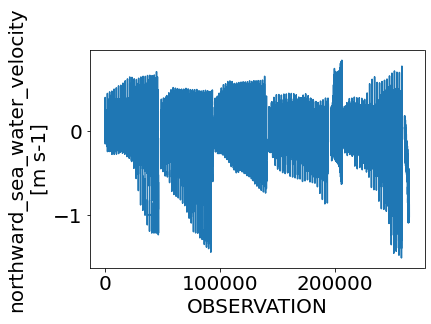

In [55]:
Vhrly_data.VCUR.plot()

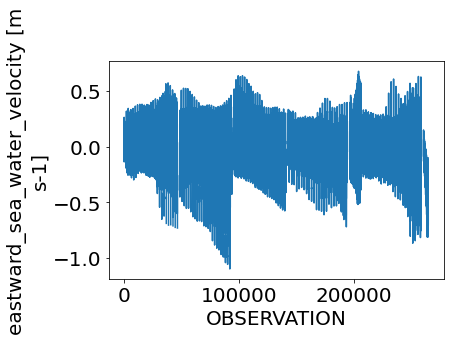

In [56]:
Vhrly_data.UCUR.plot()

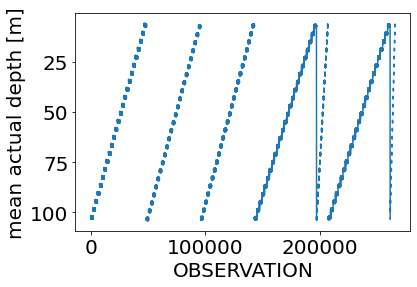

In [57]:
Vhrly_data.DEPTH.plot()
plt.gca().invert_yaxis()

(-1.0, 1.0)

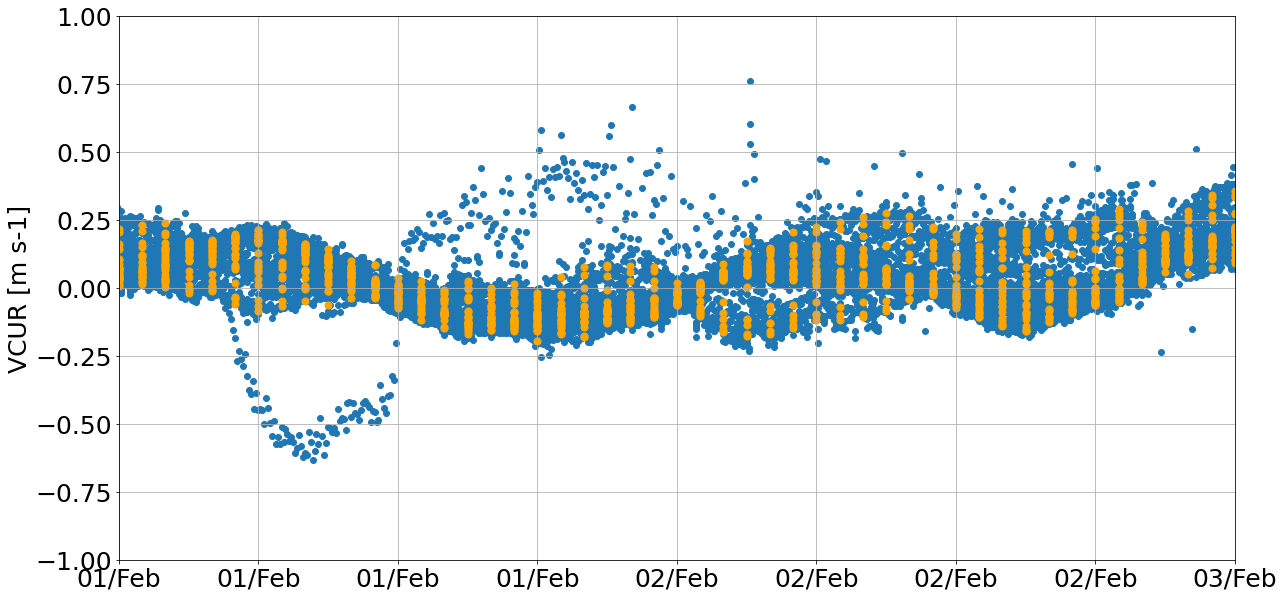

In [59]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(Vagg_data.TIME,Vagg_data.VCUR)
plt.scatter(Vhrly_data.TIME,Vhrly_data.VCUR,s=50,c='orange')
plt.xlim(left=np.datetime64('2021-02-01'),right=np.datetime64('2021-02-03'))
plt.ylabel('VCUR [m s-1]')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%h'))
plt.rc('font', size=25)
plt.grid()
plt.ylim(-1,1)

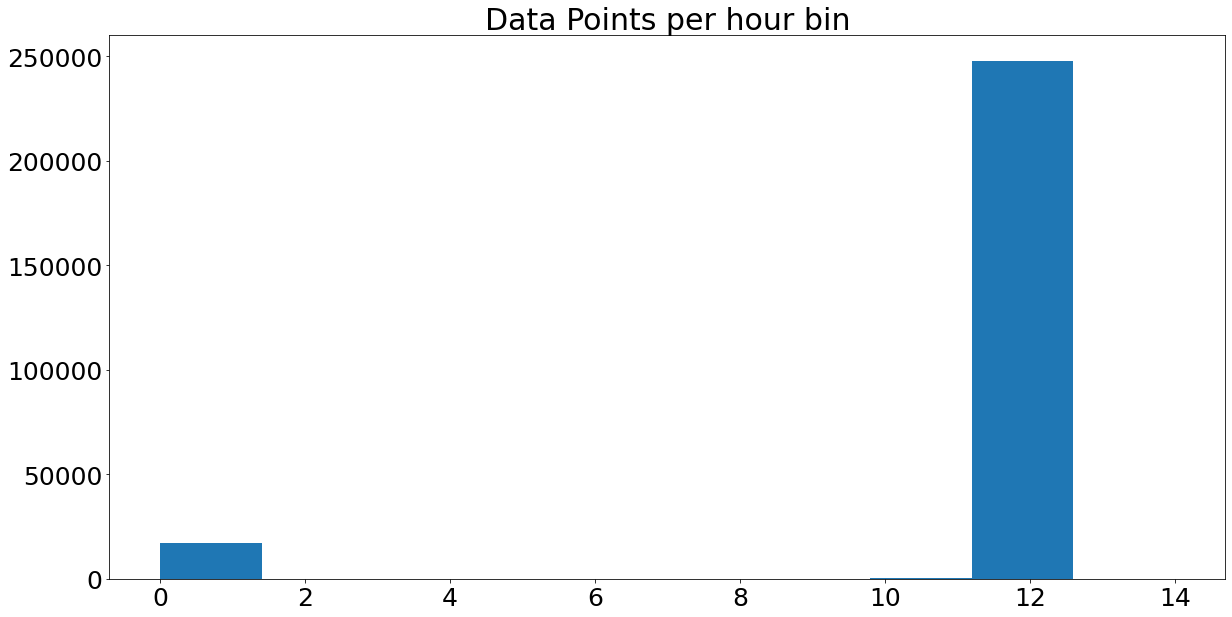

In [66]:
fig, ax = plt.subplots(figsize=(20,10))
plt.hist(Vhrly_data.VCUR_count,10)
plt.title('Data Points per hour bin')
plt.rc('font', size=25)

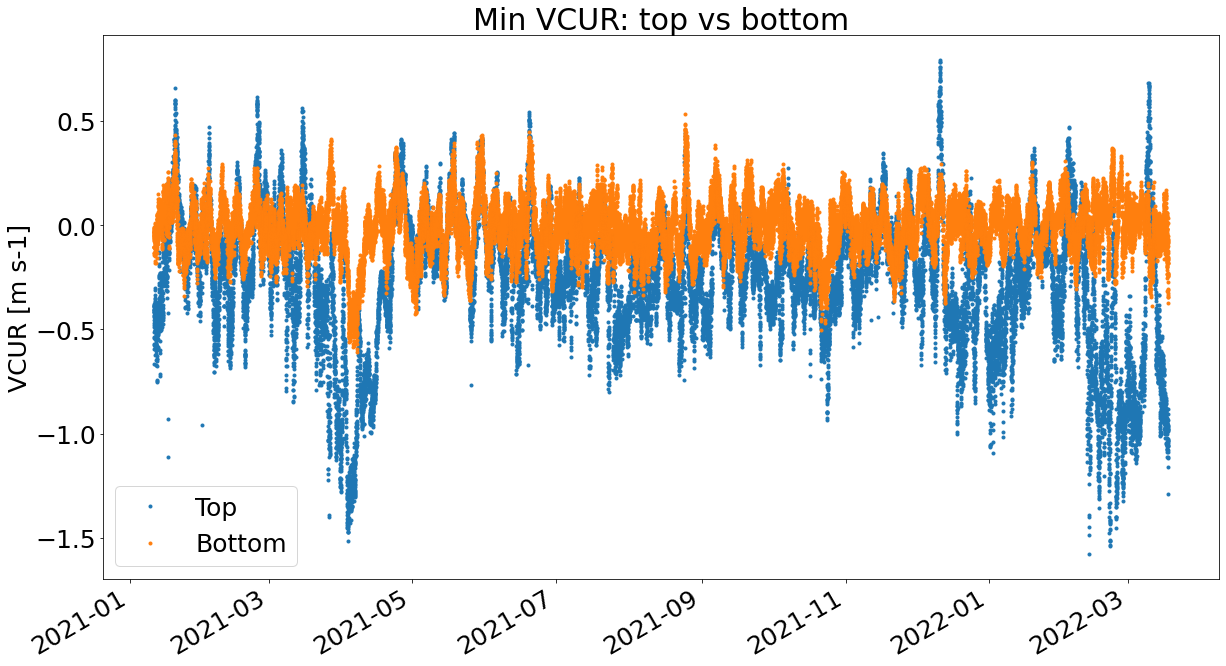

In [37]:
plt.figure(figsize=(20,10))
Vhrly_data.VCUR_min.where(Vhrly_data.DEPTH< 20).plot(x='TIME',linewidth=1,label='Top',marker='.',linestyle='')
Vhrly_data.VCUR_min.where(Vhrly_data.DEPTH > 90).plot(x='TIME',linewidth=1,label='Bottom',marker='.',linestyle='')
plt.legend()
plt.ylabel('VCUR [m s-1]'); plt.xlabel('')
plt.title('Min VCUR: top vs bottom')
plt.rc('font', size=25)

## Gridded version from hourly product?

### Doesn't yet exist... Marty working on it I think

## getting mean temperature and velocity profiles

In [40]:
def bin_var_in_depth(dataset,variable,bins):
    interval = np.nanmean(np.diff(bins))/2
    # create containers
    binned_var = np.ones(np.size(bins))*np.nan
    binned_var_std = np.ones(np.size(bins))*np.nan
    binned_var_med = np.ones(np.size(bins))*np.nan
    # bin data
    for bin_n in range(len(bins)-1):
        print(str(bins[bin_n]) + ' m')
        
        c = np.logical_and(dataset.DEPTH > bins[bin_n],
                           dataset.DEPTH <= bins[bin_n+1])
        
        binned_var[bin_n] = np.nanmean(dataset[variable][c])
        binned_var_std[bin_n] = np.nanstd(dataset[variable][c])
        binned_var_med[bin_n] = np.nanmedian(dataset[variable][c])
        
    class output:
        mean = binned_var
        median = binned_var_med
        standard_dev = binned_var_std
        depth = bins+interval
        
    return output 
        

In [41]:
# get 1-m binned profiles over whole time series
# D_groups = Vhrly_data.VCUR.groupby('DEPTH')

bins = list(range(0,120,5))
dataset = Vhrly_data
# bin velocities
variable = 'VCUR'
VCURbinned = bin_var_in_depth(dataset,variable,bins)
variable = 'UCUR'
UCURbinned = bin_var_in_depth(dataset,variable,bins)

0 m
5 m


/var/folders/kr/fd_s7b4976jdz1z0tdk7cry40000gp/T/ipykernel_2082/521974397.py:14: RuntimeWarning: Mean of empty slice
  binned_var[bin_n] = np.nanmean(dataset[variable][c])
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


10 m
15 m
20 m
25 m
30 m
35 m
40 m
45 m
50 m
55 m
60 m
65 m
70 m
75 m
80 m
85 m
90 m
95 m
100 m
105 m
110 m
0 m
5 m


/var/folders/kr/fd_s7b4976jdz1z0tdk7cry40000gp/T/ipykernel_2082/521974397.py:14: RuntimeWarning: Mean of empty slice
  binned_var[bin_n] = np.nanmean(dataset[variable][c])
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/kr/fd_s7b4976jdz1z0tdk7cry40000gp/T/ipykernel_2082/521974397.py:14: RuntimeWarning: Mean of empty slice
  binned_var[bin_n] = np.nanmean(dataset[variable][c])
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
 

10 m
15 m
20 m
25 m
30 m
35 m
40 m
45 m
50 m
55 m
60 m
65 m
70 m
75 m
80 m
85 m
90 m
95 m
100 m
105 m
110 m


/var/folders/kr/fd_s7b4976jdz1z0tdk7cry40000gp/T/ipykernel_2082/521974397.py:14: RuntimeWarning: Mean of empty slice
  binned_var[bin_n] = np.nanmean(dataset[variable][c])
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/kr/fd_s7b4976jdz1z0tdk7cry40000gp/T/ipykernel_2082/521974397.py:14: RuntimeWarning: Mean of empty slice
  binned_var[bin_n] = np.nanmean(dataset[variable][c])
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
 

In [107]:
UCURbinned.mean

array([        nan, -0.09681047, -0.13432261, -0.1317123 , -0.1143605 ,
       -0.10462704, -0.08994569, -0.08575603, -0.07257326, -0.06643476,
       -0.05841559, -0.05200841, -0.0424813 , -0.03629673, -0.02841402,
       -0.02077529, -0.01255819, -0.00672733,  0.0004519 ,  0.00983875,
        0.01695819,         nan,         nan,         nan])

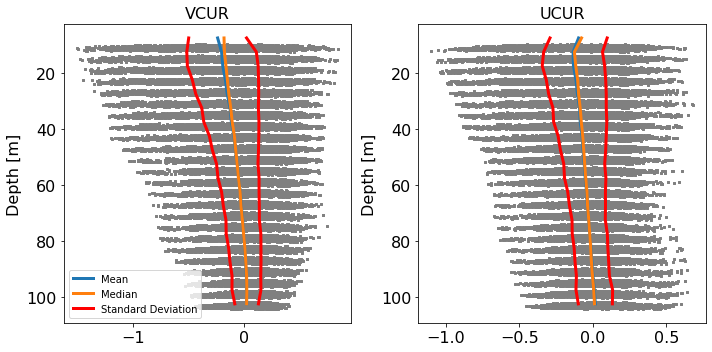

In [113]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# plot VCUR
ax1.scatter(dataset.VCUR,dataset.DEPTH,s=2,marker='s',color='gray')
ax1.plot(VCURbinned.mean,VCURbinned.depth,linewidth=3,label='Mean')
ax1.plot(VCURbinned.median,VCURbinned.depth,linewidth=3,label='Median')
ax1.plot(VCURbinned.mean+VCURbinned.standard_dev,VCURbinned.depth,linewidth=3,color='r',label='Standard Deviation')
ax1.plot(VCURbinned.mean-VCURbinned.standard_dev,VCURbinned.depth,linewidth=3,color='r')
ax1.invert_yaxis()
ax1.set_ylabel('Depth [m]',fontsize=16)
ax1.set_title('VCUR',fontsize=16)
ax1.tick_params(labelsize=16)
ax1.legend(fontsize=10)
# plot UCUR
ax2.scatter(dataset.UCUR,dataset.DEPTH,s=2,marker='s',color='gray')
ax2.plot(UCURbinned.mean,UCURbinned.depth,linewidth=3,label='Mean')
ax2.plot(UCURbinned.median,UCURbinned.depth,linewidth=3,label='Median')
ax2.plot(UCURbinned.mean+UCURbinned.standard_dev,UCURbinned.depth,linewidth=3,color='r',label='Standard Deviation')
ax2.plot(UCURbinned.mean-UCURbinned.standard_dev,UCURbinned.depth,linewidth=3,color='r')
ax2.invert_yaxis()
ax2.set_ylabel('Depth [m]',fontsize=16)
ax2.set_title('UCUR',fontsize=16)
ax2.tick_params(labelsize=16)

plt.tight_layout()

In [38]:
plt.hist(dataset.VCUR)

NameError: name 'dataset' is not defined

In [114]:
# altair and seaborne packages, python griddata

# What next? (to discuss)

*  Tidy up gridding function
*  Hourly-average gridded product 
*  Compare two gridded versions (Hourly, then gridded vs. gridded, then hourly), and choose which is best
*  Run code at all sites, for complete time series
*  Save data files and produce figures
